In [1]:
# =========================== INSTALL ===========================
!pip install -q langchain sentence-transformers groq langchain-groq faiss-cpu pypdf openai langchain-community langgraph langchain-openai ragas datasets pandas numpy langchain-huggingface
!pip install -q --upgrade ragas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.8/130.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.5/305.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.4/70.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.

In [71]:
# =========================== IMPORTS ===========================
import os
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain_core.prompts import PromptTemplate
from langchain_groq import ChatGroq
from langchain_core.runnables import RunnableLambda, RunnableMap, RunnablePassthrough
from langgraph.graph import StateGraph, END
from IPython.display import display, Markdown
import networkx as nx
from langchain_openai import ChatOpenAI

In [72]:
# =========================== STATE ===========================
from typing import TypedDict
from google.colab import userdata
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY_')
class SetupChainState(TypedDict):
    pdf_path: str
    loader: object
    documents: list
    splitter: object
    docs: list
    embedding_model: object
    vectorstore: object
    retriever: object
    llm: object
    prompt: object

In [73]:

# =========================== NODES ===========================
from google.colab import userdata
# Load PDF
def load_pdf_node(state):
    loader = PyPDFLoader(state["pdf_path"])
    documents = loader.load_and_split()
    state["loader"] = loader
    state["documents"] = documents
    print(f"Loaded {len(documents)} pages")
    return state

# Split Text
def split_text_node(state):
    splitter = CharacterTextSplitter(chunk_size=500, chunk_overlap=50)
    docs = splitter.split_documents(state["documents"])
    state["splitter"] = splitter
    state["docs"] = docs
    print(f"Total chunks: {len(docs)}")
    return state

# Create Embeddings + Vectorstore
def embed_vectorstore_node(state):
    embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
    vectorstore = FAISS.from_documents(state["docs"], embedding_model)
    retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k":5}, lambda_mult=0.3)
    state["embedding_model"] = embedding_model
    state["vectorstore"] = vectorstore
    state["retriever"] = retriever
    print("Embedding model and vectorstore created")
    return state

# Configure LLM + Prompt
def llm_prompt_node(state):
    llm = ChatOpenAI(model_name="gpt-4o-mini",
                     openai_api_key=os.environ['OPENAI_API_KEY'],
                     temperature=0.1,
                     max_tokens=1024)
    prompt = PromptTemplate.from_template(
        "Use the following context to answer the question:\n\n{context}\n\nQuestion: {question}"
    )
    state["llm"] = llm
    state["prompt"] = prompt
    print("LLM and Prompt configured")
    return state

In [74]:
# =========================== SETUP GRAPH ===========================
setup_graph = StateGraph(SetupChainState)

setup_graph.add_node("LoadPDF", load_pdf_node)
setup_graph.add_node("SplitText", split_text_node)
setup_graph.add_node("EmbedVectorstore", embed_vectorstore_node)
setup_graph.add_node("LLMConfig", llm_prompt_node)

setup_graph.set_entry_point("LoadPDF")
setup_graph.add_edge("LoadPDF", "SplitText")
setup_graph.add_edge("SplitText", "EmbedVectorstore")
setup_graph.add_edge("EmbedVectorstore", "LLMConfig")
setup_graph.add_edge("LLMConfig", END)

## Setup Chain Graph

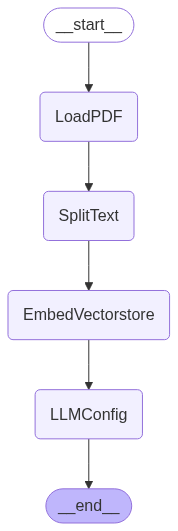

In [75]:
# =========================== VISUALIZE ===========================
chat_graph = setup_graph.compile()
display(Markdown("## Setup Chain Graph"))
from IPython.display import Image
Image(chat_graph.get_graph().draw_mermaid_png())

In [76]:
# =========================== RUN SETUP CHAIN ===========================
setup_app = setup_graph.compile()

pdf_path = "/content/solid-python.pdf"
setup_state = setup_app.invoke({"pdf_path": pdf_path})
print("\n Setup Chain Output State:")
for k in setup_state:
    print(f"{k}: {type(setup_state[k])}")

Loaded 22 pages
Total chunks: 22
Embedding model and vectorstore created
LLM and Prompt configured

 Setup Chain Output State:
pdf_path: <class 'str'>
loader: <class 'langchain_community.document_loaders.pdf.PyPDFLoader'>
documents: <class 'list'>
splitter: <class 'langchain_text_splitters.character.CharacterTextSplitter'>
docs: <class 'list'>
embedding_model: <class 'langchain_community.embeddings.huggingface.HuggingFaceEmbeddings'>
vectorstore: <class 'langchain_community.vectorstores.faiss.FAISS'>
retriever: <class 'langchain_core.vectorstores.base.VectorStoreRetriever'>
llm: <class 'langchain_openai.chat_models.base.ChatOpenAI'>
prompt: <class 'langchain_core.prompts.prompt.PromptTemplate'>


In [89]:
from langgraph.graph import MessagesState
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import faithfulness, answer_relevancy, context_recall, context_precision, FactualCorrectness
import numpy as np

class RAGChainState(MessagesState):
    context: list[str]  # retrieved chunks
    answer: str         # final answer
    question: str       # user question
    ragas_data_input: dict # Data to create RAGAS dataset
    ragas_scores: dict      # Holds all 5 RAGAS metrics

In [122]:
# =========================== NODES ===========================

# Retrieve
def retrieve_node(state):
    retriever = setup_state["retriever"]
    relevant_docs = retriever.get_relevant_documents(state["question"])
    state["context"] = [doc.page_content for doc in relevant_docs]
    print(f"Retrieved {len(state['context'])} chunks")
    return state

# Prompt
def agumentation_prompt_node(state):
    prompt = setup_state["prompt"]
    formatted_prompt = prompt.format(context="\n\n".join(state["context"]), question=state["question"])
    state["messages"] = [formatted_prompt]
    print("Prompt formatted")
    return state

#SetDataset
def dataset_setup_node(state):
    # Prepare data for RAGAS dataset
    ground_truths = ["The main objective of the document is to explain solid python principles."]
    ragas_data_input = {
        "question": [state["question"]],
        "answer": [""],  # Placeholder for now
        "contexts": [state["context"]],
        "ground_truths": [ground_truths],
        "reference": [ground_truths[0]] # Add the 'reference' column
    }
    state["ragas_data_input"] = ragas_data_input
    print("RAGAS data input prepared")
    return state

#Evaluation
def ragas_evaluation_node(state):
    # Reconstruct RAGAS dataset from stored data input
    ragas_data = Dataset.from_dict(state["ragas_data_input"])

    # Update the answer column before evaluation
    ragas_data = ragas_data.map(lambda example: {"answer": state.get("answer", "")})

    results = evaluate(
        ragas_data,
        metrics=[
            context_precision, # Added () back
            context_recall,    # Added () back
            faithfulness,      # Added () back
            answer_relevancy,  # Added () back
            FactualCorrectness(), # Added () back
        ]
    )
    ragas_scores = results.to_pandas().to_dict(orient="records")[0]
    # Ensure all keys are strings for serialization
    # print(results)
    state["ragas_scores"] = {str(k): v for k, v in ragas_scores.items()}
    print(f"RAGAS Scores: {state['ragas_scores']}")
    return state

# LLM Invoke
def generation_llm_node(state):
    llm = setup_state["llm"]
    answer = llm.invoke(state["messages"])
    state["answer"] = answer.content
    print("Answer generated")
    return state

In [123]:
# =========================== RAG GRAPH ===========================
rag_graph = StateGraph(RAGChainState)

rag_graph.add_node("Retrieve", retrieve_node)
rag_graph.add_node("Agumentation", agumentation_prompt_node)
rag_graph.add_node("DatasetSetup", dataset_setup_node)
rag_graph.add_node("RAGASEvaluation", ragas_evaluation_node)
rag_graph.add_node("Generation", generation_llm_node)

# Edges
rag_graph.set_entry_point("Retrieve")
rag_graph.add_edge("Retrieve", "Agumentation")
rag_graph.add_edge("Agumentation", "DatasetSetup")
rag_graph.add_edge("DatasetSetup", "RAGASEvaluation")
rag_graph.add_edge("RAGASEvaluation", "Generation")
rag_graph.add_edge("Generation", END)

## Updated RAG Chain Graph with RAGAS Nodes

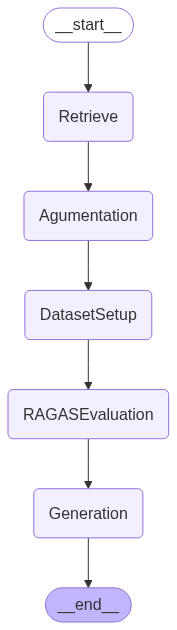

In [124]:
# =========================== VISUALIZE ===========================
app = rag_graph.compile()
display(Markdown("## Updated RAG Chain Graph with RAGAS Nodes"))
from IPython.display import Image
Image(app.get_graph().draw_mermaid_png())

In [125]:
# =========================== RUN RAG CHAIN ===========================
from langgraph.checkpoint.memory import InMemorySaver

memory = InMemorySaver()
app = rag_graph.compile(checkpointer=memory)

question_input = {"question": "What is the main objective of the document?"}
state = app.invoke(question_input, config={"configurable": {"thread_id": "some-thread-id"}})

Retrieved 5 chunks
Prompt formatted
RAGAS data input prepared


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

RAGAS Scores: {'user_input': 'What is the main objective of the document?', 'retrieved_contexts': ["Aspects of a Class\nThursday, Feb 22nd 2024 19/22\nThe 5 aspects of the class are:\na\nresponsibility towards parent\ninterface towards callers\ninterface towards callees\nresponsibility towards inheritors\nclass'\npurpose\na\nMike Lindner: The Five Principles For SOLID Software Design", 'Motivation\nThursday, Feb 22nd 2024 2/22\nFind guiding design principles to\nmaintain software quality over\ntime.', 'Single Responsibility - Before\nThursday, Feb 22nd 2024 7/22\ndef adults_to_html(people):\nresult = "<ul>\\n"\nfor person in people:\nif person.age >= 18:\nresult += " <li>" + person.name + "</li>\\n"\nresult += "</ul>"\nreturn result\n# ...\npage = adults_to_html(people)', 'Liskov-Substitution - Contracts\nThursday, Feb 22nd 2024 13/22\n“The Liskov Substitution Principle states, among other constraints,\nthat a subtype is not substitutable for its super type if it\nstrengthens its opera

In [126]:
print("\nFinal Answer:", state["answer"])
print("\nRAGAS Scores:\nContext_precision: ", state["ragas_scores"]['context_precision'])
print("Faithfulness: ",state["ragas_scores"]['faithfulness'])
print("Answer_relevancy: ",state["ragas_scores"]['answer_relevancy'])
print("Factual_correctness(mode=f1): ",state["ragas_scores"]['factual_correctness(mode=f1)'])
print("Context_recall: ",state["ragas_scores"]['context_recall'])


Final Answer: The main objective of the document is to outline guiding design principles for maintaining software quality over time, specifically focusing on the SOLID principles of software design. These principles include aspects such as single responsibility, Liskov substitution, and dependency inversion, which aim to improve the structure and maintainability of software systems.

RAGAS Scores:
Context_precision:  0.0
Faithfulness:  nan
Answer_relevancy:  0.0
Factual_correctness(mode=f1):  0.0
Context_recall:  1.0
